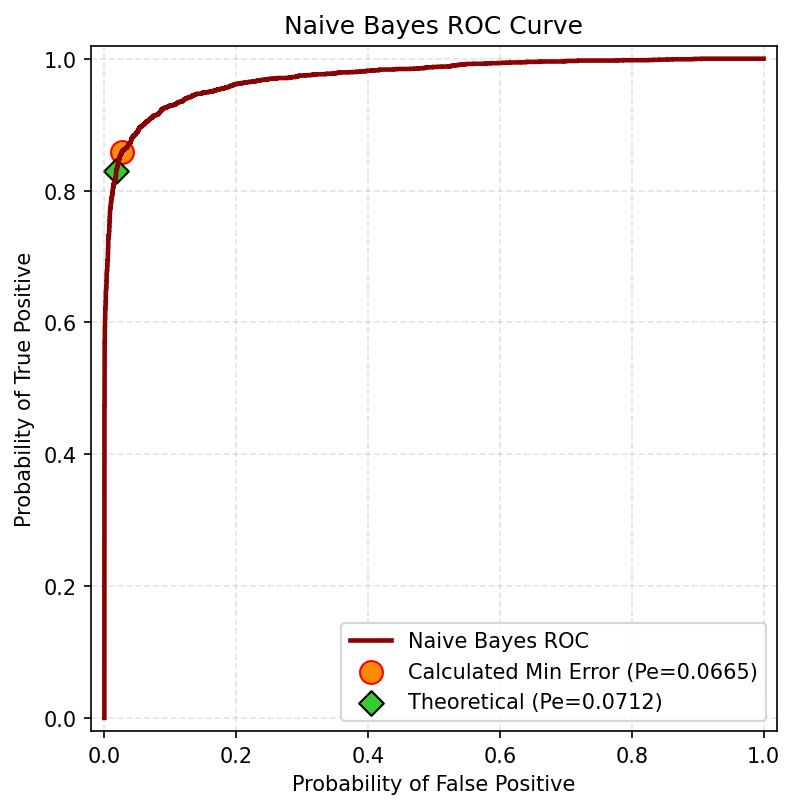


Naive Bayes ROC calculations:
Calculated tau*: 0.252288; Calculated gamma*: 1.286967
Calculated: FPR=0.0264; Calculated TPR=0.8589; Calculated Pe=0.06654

Theoretical tau*: 0.619039; Theoretical gamma*: 1.857143
Theoretical: FPR=0.0180; Theoretical TPR=0.8301; Theoretical Pe=0.07119


In [17]:
import numpy as np
import matplotlib.pyplot as plt

N = 10000
p0, p1 = 0.65, 0.35
rng = np.random.default_rng(5)

m0 = np.array([-0.5, -0.5, -0.5])
C0 = np.array([[1.0, -0.5,  0.3],
               [-0.5, 1.0, -0.5],
               [ 0.3, -0.5,  1.0]])
m1 = np.array([1.0, 1.0, 1.0])
C1 = np.array([[1.0,  0.3, -0.2],
               [0.3,  1.0,  0.3],
               [-0.2, 0.3,  1.0]])

labels = (rng.random(N) < p1).astype(int)
N1, N0 = labels.sum(), N - labels.sum()

def sample_gaussian(mean, cov, n):
    w, V = np.linalg.eigh(cov)
    A = V @ np.diag(np.sqrt(np.maximum(w, 0)))
    z = rng.standard_normal((n, len(mean)))
    return z @ A.T + mean

X0 = sample_gaussian(m0, C0, N0)
X1 = sample_gaussian(m1, C1, N1)
X  = np.vstack((X0, X1))
y  = np.concatenate((np.zeros(N0, int), np.ones(N1, int)))

x_m1, x_m0 = X - m1, X - m0
score_nb = (-0.5 * np.einsum('ij,ij->i', x_m1, x_m1) + 0.5 * np.einsum('ij,ij->i', x_m0, x_m0))

order = np.argsort(score_nb)
s, yl = score_nb[order], y[order]

P1, P0 = (y == 1).sum(), (y == 0).sum()
mid = (s[:-1] + s[1:]) / 2
taus = np.concatenate(([-np.inf], mid, [np.inf]))

tp_cum = np.cumsum(yl[::-1])[::-1]
fp_cum = np.cumsum((1 - yl)[::-1])[::-1]

TP = np.empty_like(taus, float); FP = np.empty_like(taus, float)
TP[0], FP[0] = P1, P0
TP[1:-1], FP[1:-1] = tp_cum[1:], fp_cum[1:]
TP[-1], FP[-1] = 0, 0

TPR = TP / P1
FPR = FP / P0
P_error = FPR * p0 + (1 - TPR) * p1

i_emp = int(np.argmin(P_error))
tau_emp = taus[i_emp]
gamma_emp = np.exp(tau_emp) if np.isfinite(tau_emp) else np.inf
fpr_emp, tpr_emp, pe_emp = FPR[i_emp], TPR[i_emp], P_error[i_emp]

gamma_the = p0 / p1
tau_the = np.log(gamma_the)
i_the = int(np.searchsorted(s, tau_the, side="right"))
i_the = np.clip(i_the, 0, len(TPR)-1)
fpr_the, tpr_the, pe_the = FPR[i_the], TPR[i_the], P_error[i_the]

plt.figure(figsize=(7, 5.5), dpi=150)
plt.plot(FPR, TPR, color="darkred", linewidth=2.2, label="Naive Bayes ROC")
plt.scatter(fpr_emp, tpr_emp, s=120, color="darkorange", edgecolor="red",label=f"Calculated Min Error (Pe={pe_emp:.4f})")
plt.scatter(fpr_the, tpr_the, s=70, marker="D", color="limegreen", edgecolor="k", label=f"Theoretical (Pe={pe_the:.4f})")

plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("Probability of False Positive")
plt.ylabel("Probability of True Positive")
plt.title("Naive Bayes ROC Curve")
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend(loc="lower right", frameon=True)
plt.tight_layout()
plt.show()

print("\nNaive Bayes ROC calculations:")
print(f"Calculated tau*: {tau_emp:.6f}; Calculated gamma*: {gamma_emp:.6f}")
print(f"Calculated: FPR={fpr_emp:.4f}; Calculated TPR={tpr_emp:.4f}; Calculated Pe={pe_emp:.5f}")
print(f"\nTheoretical tau*: {tau_the:.6f}; Theoretical gamma*: {gamma_the:.6f}")
print(f"Theoretical: FPR={fpr_the:.4f}; Theoretical TPR={tpr_the:.4f}; Theoretical Pe={pe_the:.5f}")
